In [1]:
import essentia
print(essentia.__version__)
print(essentia.__file__)
import essentia.standard , essentia.streaming
from essentia.standard import MonoLoader, TensorflowPredictFSDSINet

# let's have a look at what is in there
#print(dir(essentia.standard))

import utils.util as util

import json
import matplotlib.pyplot as plt
import numpy as np

2.1-beta6-dev
/usr/local/lib/python3.8/site-packages/essentia/__init__.py


2023-03-31 16:07:29.167887: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
mp4_fn,mp4_labels,aac_fn,aac_labels = util.load_xdv_test(util.SERVER_TEST_AUD_MONO_PATH)
audio = MonoLoader(filename=aac_fn[17], sampleRate=22050)()

acc_path /raid/DATASETS/anomaly/XD_Violence/aud/testing/mono


In [3]:
'''
model files
    https://essentia.upf.edu/models/audio-event-recognition/fsd-sinet/    
    !wget -q https://essentia.upf.edu/models/audio-event-recognition/fsd-sinet/fsd-sinet-vgg41-tlpf-1.pb
    !wget -q https://essentia.upf.edu/models/audio-event-recognition/fsd-sinet/fsd-sinet-vgg41-tlpf-1.json


https://mtg.github.io/essentia-labs/news/tensorflow/2023/02/08/fsdsinet-models/
    tlpf : Trainable Low-Pass Filters
    aps : Adaptive Polyphase Sampling

    fsd-sinet-vgg42-tlpf_aps-1 - best
    fsd-sinet-vgg41-tlpf-1 - lighter
'''

graph_filename = "/raid/DATASETS/.zuble/vigia/zuwav/fsd-sinet-essentia/models/fsd-sinet-vgg42-aps-1.pb"
model = TensorflowPredictFSDSINet(graphFilename=graph_filename)

predictions = model(audio)

[   INFO   ] TensorflowPredict: Successfully loaded graph file: `/raid/DATASETS/.zuble/vigia/zuwav/fsd-sinet-essentia/models/fsd-sinet-vgg42-aps-1.pb`
2023-03-31 16:07:34.027466: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2198820000 Hz


In [4]:
def top_from_average(data, top_n=10):
    av = np.mean(data, axis=1)
    sorting = np.argsort(av)[::-1]
    return sorting[:top_n], [av[i] for i in sorting]

# Read the metadata
metadata_file = "/raid/DATASETS/.zuble/vigia/zuwav/fsd-sinet-essentia/models/fsd-sinet-vgg42-aps-1.json"
metadata = json.load(open(metadata_file, "r"))
labels = metadata["classes"]

for label, probability in zip(metadata['classes'], predictions.mean(axis=0)):
    print(f'{label}: {100 * probability:.1f}%') 


Accelerating and revving and vroom: 2.3%
Accordion: 0.0%
Acoustic guitar: 0.0%
Aircraft: 0.7%
Alarm: 0.4%
Animal: 9.5%
Applause: 0.2%
Bark: 0.2%
Bass drum: 0.0%
Bass guitar: 0.0%
Bathtub (filling or washing): 0.0%
Bell: 0.1%
Bicycle: 0.3%
Bicycle bell: 0.0%
Bird: 0.6%
Bird vocalization and bird call and bird song: 0.1%
Boat and Water vehicle: 1.1%
Boiling: 0.0%
Boom: 0.2%
Bowed string instrument: 0.1%
Brass instrument: 0.0%
Breathing: 0.1%
Burping and eructation: 0.0%
Bus: 0.2%
Buzz: 0.0%
Camera: 0.0%
Car: 1.3%
Car passing by: 0.1%
Cat: 0.2%
Chatter: 0.3%
Cheering: 0.1%
Chewing and mastication: 0.1%
Chicken and rooster: 0.1%
Child speech and kid speaking: 0.1%
Chime: 0.0%
Chink and clink: 0.0%
Chirp and tweet: 0.1%
Chuckle and chortle: 0.0%
Church bell: 0.0%
Clapping: 0.0%
Clock: 0.1%
Coin (dropping): 1.0%
Computer keyboard: 0.1%
Conversation: 3.2%
Cough: 0.1%
Cowbell: 0.0%
Crack: 0.0%
Crackle: 0.8%
Crash cymbal: 0.0%
Cricket: 0.0%
Crow: 0.0%
Crowd: 0.4%
Crumpling and crinkling: 0.4%
C

Text(0.5, 0, '(s)')

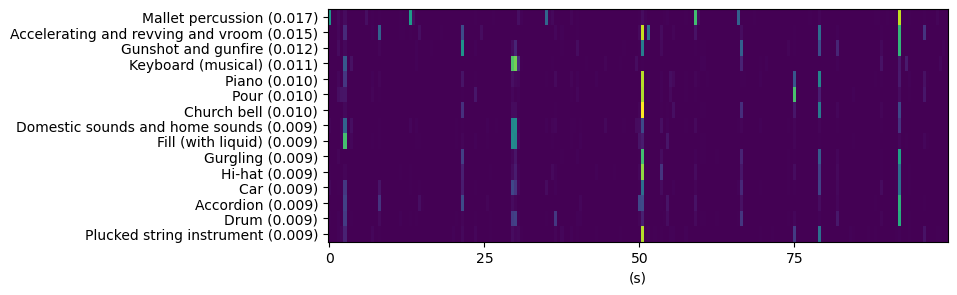

In [5]:

# Compute the top-n labels and predictions
top_n, averages = top_from_average(predictions, top_n=15)
top_labels = [labels[i] for i in top_n]
top_labels_with_av = [
    f"{label} ({av:.3f})" for label, av in zip(top_labels, averages)
]

top_predictions = np.array([predictions[i, :] for i in top_n])

# Generate plots and improve formatting
matfig = plt.figure(figsize=(8, 3))
plt.matshow(top_predictions, fignum=matfig.number, aspect="auto")

plt.yticks(np.arange(len(top_labels_with_av)), top_labels_with_av)
locs, _ = plt.xticks()
ticks = np.array(locs // 2).astype("int")
plt.xticks(locs[1: -1], ticks[1: -1])
plt.tick_params(
    bottom=True, top=False, labelbottom=True, labeltop=False
)
plt.xlabel("(s)")

#plt.savefig("predictions.png", bbox_inches='tight')
